In [1]:
import os
import sys
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import model_from_json
import shutil
from utils import load_img, gen_x_y, eval_loss, gen_paths, ssim_eucli_loss, random_cropping, local_sum_loss, fix_singular_shape


# Settings
dataset = "B"
rand_crop = True
%matplotlib inline

img_paths_val, img_paths_train = gen_paths(
    path_file_root='data/paths_train_val_test',
    dataset=dataset
)
img_paths_val = sorted(img_paths_val, key=lambda x: int(x.split('_')[-1].split('.')[0]))
x_val, y_val, img_paths_val = gen_x_y(img_paths_val[:], 'test')
print('Validation data size:', len(x_val), len(y_val), len(img_paths_val))
x_train, y_train, img_paths_train = gen_x_y(img_paths_train[:], 'train', augmentation_methods=['ori', 'flip'])
print('Train data size:', len(x_train), len(y_train), len(img_paths_train))
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/san/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/san/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/san/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/s

['paths_val.txt', 'paths_test.txt']
Validation data size: 316 316 316
Train data size: 800 800 400


In [2]:
import os
import shutil
from keras.optimizers import Adam
from utils import ssim_eucli_loss
from SANet import SANet


# Settings
weights_dir = 'weights_' + dataset
if os.path.exists(weights_dir):
    shutil.rmtree(weights_dir)
os.makedirs(weights_dir)
net = 'SANet'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
LOSS = 'ssim_eucli_loss'
lr = 1e-4
input_shape = (None, None, 3)#np.array((768, 1024, 3), dtype=int).tolist()

model = SANet(input_shape=input_shape, IN=False)
model.summary()
optimizer = Adam(lr=lr)
model.compile(optimizer=optimizer, loss=ssim_eucli_loss)
from keras.utils import plot_model
plot_model(model, 'models/{}.png'.format(net))





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 128         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, None, None, 3 128         input_1[0][0]                    
__________________________________________________________________________________________________
activa

trainable_choice: 0




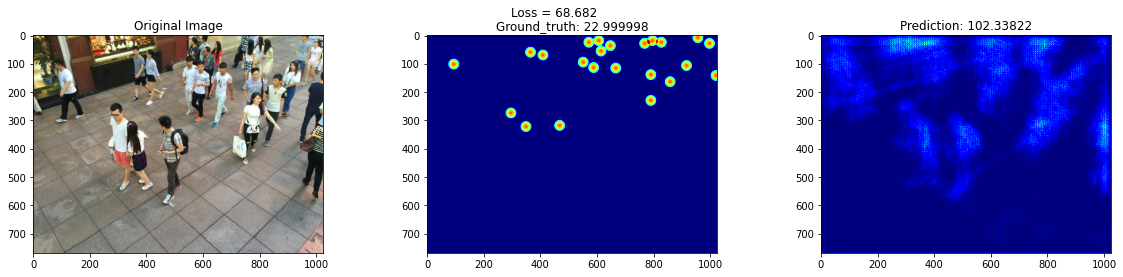

trainable_choice: 0MAE=68.682, MSE=87.55, MAPE=1.002, MDMD=20.876, time consuming=2m-26s


In [ ]:
# Settings
lossMAE = 1e5
lossMDMD, lossMAPE, lossMSE = -1, -1, -1
counter_train = 0
mae = 1e5
mdmd = 1e5
val_rate = 0.25
lossesMDMD = []
lossesMAE = []
lossesMAPE = []
lossesMSE = []
path_val_display = img_paths_val[0]
x_val_display = load_img(path_val_display)
y_val_display = np.squeeze(y_val[0])
x_val_display, y_val_display = fix_singular_shape(x_val_display), fix_singular_shape(y_val_display)
with open('./models/{}.json'.format(net), 'w') as fout:
    fout.write(model.to_json())
if dataset == 'A':
    save_frequencies = [(90, 0.1), (80, 0.05), (95, 0.25)]
else:
    save_frequencies = [(20, 0.1), (15, 0.05), (22, 0.25)]
# epoch_train = 100

# Set differernt modules trainable 3 Inception-like module and the Decoder module trainable seperatly.
branches_trainable = [
    list(range(1, 7+1)),
    list(range(8, 14+1)),
    list(range(15, 21+1)),
    list(range(22, 28+1)),
    list(range(29, 34+1))
]
if_train_seperatly = True
if if_train_seperatly:
    module_step = 40
    epoch_train_seperatly = module_step * len(branches_trainable) * 1
    epoch_train = epoch_train_seperatly + 100
else:
    epoch_train = 200

# Training
time_st = time.time()
for epoch in range(epoch_train):
    if if_train_seperatly:
        trainable_choice = int(epoch/module_step) # epoch % (5*len(branches_trainable))
        print('trainable_choice:', trainable_choice)
        # Train modules seperatly to avoid output all zeros
        if epoch < epoch_train_seperatly and trainable_choice in list(range(len(branches_trainable))):# [0, module_step*1, module_step*2, module_step*3, module_step*4, module_step*5]:
            branch_trainable = branches_trainable[trainable_choice]
            for i in range(1, len(model.layers)):
                if 'conv' in model.layers[i].name:
                    model.layers[i].trainable = False
            for i in range(1, len(model.layers)):
                idx_operator = int(model.layers[i].name.split('_')[-1])
                if 'conv' in model.layers[i].name and idx_operator in branch_trainable:
                    model.layers[i].trainable = True
            model.compile(optimizer=Adam(lr=lr), loss=ssim_eucli_loss)
        elif epoch == epoch_train_seperatly:
            for i in range(1, len(model.layers)):
                model.layers[i].trainable = True
            model.compile(optimizer=Adam(lr=lr/1), loss=ssim_eucli_loss)
        else:
            pass

#     if epoch == 35:
#         for i in range(1, 14):
#         #     print(model.layers[i].name)
#             model.layers[i].trainable = True
#         optimizer = Adam(lr=lr/10)
#         model.compile(optimizer=optimizer, loss=local_sum_loss)
    for i in range(len(x_train)):
        if lossMAE < save_frequencies[0][0]:
            val_rate = save_frequencies[0][1]
            if lossMAE < save_frequencies[1][0]:
                val_rate = save_frequencies[1][1]
        if len(lossesMAE) > 100 and val_rate <= save_frequencies[-1][-1] and np.median(lossesMAE[-20]) > save_frequencies[-1][0]:
            val_rate = save_frequencies[-1][-1]
        x_, y_ = x_train[i], y_train[i]
        model.fit(x_, y_, verbose=0)
#         x_cropped, y_cropped = random_cropping(x_, y_)
#         for idx_fit in range(x_cropped.shape[0]):
#             model.fit(x_cropped[idx_fit:idx_fit+1], y_cropped[idx_fit:idx_fit+1], verbose=0)
        counter_train += 1
#         if epoch < 5:
#             val_rate = 0.1
        if counter_train % int(len(x_train)*val_rate) == 0:
            # Calc loss
            lossMDMD, lossMAE, lossMAPE, lossMSE = eval_loss(model, x_val, y_val)
            lossesMDMD.append(lossMDMD)
            lossesMAE.append(lossMAE)
            lossesMAPE.append(lossMAPE)
            lossesMSE.append(lossMSE)
            lossMAE, lossMAPE, lossMDMD, lossMSE = round(lossMAE, 3), round(lossMAPE, 3), round(lossMDMD, 3), round(lossMSE, 3)
            if ((lossMAE < mae or lossMDMD < mdmd) and epoch >= 0) or lossMAE < save_frequencies[1][0] * 0.9:
                model.save_weights(
                    os.path.join(weights_dir, '{}_MAE{}_MSE{}_MAPE{}_MDMD{}_epoch{}-{}.hdf5'.format(
                        net, str(lossMAE), str(lossMSE), str(lossMAPE), str(lossMDMD), epoch, (counter_train-1)%len(x_train)
                    ))
                )
                if lossMAE < mae:
                    mae = lossMAE
                    model.save_weights(os.path.join(weights_dir, '{}_best.hdf5'.format(net)))
                if lossMDMD < mdmd:
                    mdmd = lossMDMD
            if counter_train % (len(x_train)*1) == 0:
                # show prediction
                pred = np.squeeze(model.predict(np.expand_dims(x_val_display, axis=0)))
                fg, (ax_x_ori, ax_y, ax_pred) = plt.subplots(1, 3, figsize=(20, 4))
                ax_x_ori.imshow(cv2.cvtColor(cv2.imread(path_val_display), cv2.COLOR_BGR2RGB))
                ax_x_ori.set_title('Original Image')
                ax_y.imshow(y_val_display, cmap=plt.cm.jet)
                ax_y.set_title('Ground_truth: ' + str(np.sum(y_val_display)))
                ax_pred.imshow(pred, cmap=plt.cm.jet)
                ax_pred.set_title('Prediction: ' + str(np.sum(pred)))
                plt.suptitle('Loss = ' + str(lossMAE))
                plt.show()
                if counter_train % (len(x_train)*4) == 0 or (epoch+1) % (20) == 0:
                    # plot val_loss
                    plt.plot(lossesMAPE, 'y')
                    plt.plot(lossesMAE, 'b')
                    plt.plot(lossesMSE, 'c')
                    plt.plot(lossesMDMD, 'r')
                    plt.legend(['LossMAPE', 'LossMAE', 'LossMSE', 'Loss_Density_Map_Distance'])
                    plt.title('Loss')
                    plt.show()
        time_now = time.time()
        time_consuming = time_now - time_st
        sys.stdout.write('In epoch {}_{}, with MAE={}, MSE={}, MAPE={}, MDMD={}, time consuming={}m-{}s\r'.format(
            epoch, counter_train%len(x_train), str(lossMAE), str(lossMSE), str(lossMAPE), str(lossMDMD),
            int(time_consuming/60), int(time_consuming-int(time_consuming/60)*60)
        ))
        sys.stdout.flush()
end_time_of_train = '-'.join(time.ctime().split()[:-2])
suffix_new_dir = '_{}_{}_bestMAE{}_{}'.format(dataset, LOSS, str(round(mae, 3)), end_time_of_train)
shutil.move('weights_{}'.format(dataset), 'weights'+suffix_new_dir)

loss_dir = 'losses_' + dataset
if not os.path.exists(loss_dir):
    os.makedirs(loss_dir)
np.savetxt(os.path.join(loss_dir, 'loss_DMD.txt'), lossesMDMD)
np.savetxt(os.path.join(loss_dir, 'loss_MAE.txt'), lossesMAE)
np.savetxt(os.path.join(loss_dir, 'loss_MAPE.txt'), lossesMAPE)
np.savetxt(os.path.join(loss_dir, 'loss_MSE.txt'), lossesMSE)
plt.plot(lossesMAPE, 'y')
plt.plot(lossesMAE, 'b')
plt.plot(lossesMSE, 'c')
plt.plot(lossesMDMD, 'r')
plt.legend(['LossMAPE', 'LossMAE', 'LossMSE', 'Loss_Density_Map_Distance'])
plt.title('Loss -- {} epochs'.format(epoch_train))
plt.savefig('./losses_{}/loss_{}_{}.jpg'.format(dataset, dataset, end_time_of_train))
plt.show()
shutil.move('losses_{}'.format(dataset), 'losses'+suffix_new_dir)